# History Matching for L96
Author : Homer Durand

Date : 27-07-21

### Loading libs

In [1]:
mogp_dir <- "/home/homer/Documents/Locean/HistoryMatching/mogp-emulator" #mogp_emulator lib

setwd('/home/homer/Documents/Locean/HistoryMatching/dev_ExeterUQ_MOGP/') #setting working directory to dev_ExeterUQ_MOGP and load libs

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd('/home/homer/Documents/Locean/HistoryMatching/libs/') #setting wd to libs and load personnal libs for preprocessing and refocussing
source("../libs/unPreProc.R")

setwd('/home/homer/Documents/Locean/AMIP/') #setting wd to libs and load personnal libs for preprocessing and refocussing
L96_amip <- import("L96_amip")
data_generation <- import("data_generation")
setwd('/home/homer/Documents/Locean/HistoryMatching/libs/') #setting wd to libs and load personnal libs for preprocessing and refocussing
np <- import("numpy")
smt <- import("smt")
sklearn <- import("sklearn")

packages <- c("FactoMineR", "factoextra", "corrplot", 'kernlab', 'pca3d', 'BBmisc', 'comprehenr', 'caret', "future.apply", 'tgp', 'ANN2', 'ramify', 'keras', 'MLmetrics')
# Install packages not yet installed
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Packages loading
invisible(lapply(packages, library, character.only = TRUE))

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.88 loaded

# History Matching with dimensionality reduction

1. Space filling design of parameters space
2. Data simulation
3. Dimensionality reduction with PCA (EOF) or AE
4. Training of statistical emulator
5. Computation of implausibility
6. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation


In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model.
We then iterate for n_iter iterations and use this history as an observation of the real model.
We save the history of X in order to reinject it during the Y integration.

In [3]:
n_iter <- 5 
dt <- 0.001
l96_two$iterate(10)
Newinit = l96_two$X
np$random$seed(as.integer(42))
l96_two = L96_amip$L96TwoLevel(save_dt=dt, X_init=Newinit, integration_type='coupled') 
l96_two$iterate(n_iter)
X_hist <- l96_two$history$X$values

We save the metrics generate with the ground truth parameters (observations).

In [4]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0)))

   user  system elapsed 
  0.561   0.004   0.568 

### Generation of metrics for the first wave

In [5]:
sampler <- import('skopt.sampler')
skSpace <- import('skopt.space')

In [6]:
n_samples <- 30

In [7]:
space <- skSpace$Space(list(c(-2, 2), c(0, 20), c(-20, 20))) ##only h,c,b
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

In [8]:
extract_metrics_AMIP <- function(p, n_iter, dt, X_hist) {
    initX <- as.matrix(X_hist[1,])
    l96_mip = L96_amip$L96TwoLevel(X_init=initX, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=10, c=p[[2]], b=p[[3]])
    l96_mip$iterate_AMIP(X_hist, n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0)))
}

In [9]:
plan(multicore)
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics_AMIP(inputs_wave1[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

## Dimensonality reduction of metrics space

In [10]:
n_samples_test <- 30
inputs_test <- np$array(lhs$generate(space$dimensions, as.integer(n_samples_test), random_state=as.integer(21)))

In [11]:
metrics_test = future_sapply(1:nrow(inputs_test), function(r) extract_metrics_AMIP(inputs_test[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

In [12]:
# Scale metrics
my.scaler <- sklearn$preprocessing$StandardScaler()
X <- my.scaler$fit_transform(t(metrics_wave1))
X_test <- my.scaler$fit_transform(t(metrics_test))
input_size = dim(X)[[2]]

### Principal Component Analysis

In [13]:
pca <- sklearn$decomposition$PCA(n_components=as.integer(16))
X_pca <- pca$fit_transform(X)
X_pca_test <- pca$transform(X_test)
X_inverse_transform <- pca$inverse_transform(X_pca)
X_test_inverse_transform <- pca$inverse_transform(X_pca_test)
mse <- MSE(X_inverse_transform, X)
val_mse <- MSE(X_test_inverse_transform, X_test)
mse
val_mse

[1] 0.0007512151

[1] 0.01770319

### Autoencoder

In [14]:
latent_size <- 128

#Create encoder
enc_input = layer_input(shape = input_size)
enc_output = enc_input %>% 
  layer_dense(units=latent_size, activation = "sigmoid") 
encoder = keras_model(enc_input, enc_output)

#Create decoder
dec_input = layer_input(shape = latent_size)
dec_output = dec_input %>% 
  layer_dense(units = input_size, activation = "linear") %>%
  layer_dropout(rate=0.2)
decoder = keras_model(dec_input, dec_output)

#Create autoencoder
aen_input = layer_input(shape = input_size)
aen_output = aen_input %>% 
  encoder() %>% 
  decoder()
   
ae = keras_model(aen_input, aen_output)
summary(ae)

Model: "model_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_3 (InputLayer)                [(None, 2340)]                  0           
________________________________________________________________________________
model (Functional)                  (None, 128)                     299648      
________________________________________________________________________________
model_1 (Functional)                (None, 2340)                    301860      
Total params: 601,508
Trainable params: 601,508
Non-trainable params: 0
________________________________________________________________________________


In [15]:
ae %>% compile(optimizer="Adam", loss="mean_squared_error")
ae %>% fit(X,X, epochs=300, batch_size=16, validation_data =list(X_test, X_test))

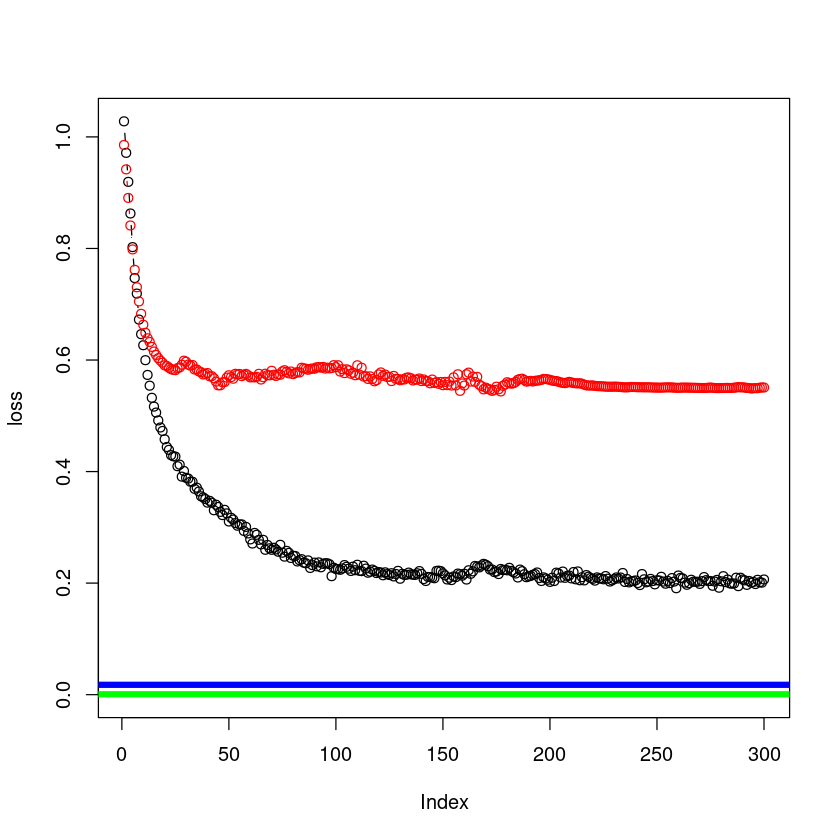

In [16]:
loss <- ae$history$history$loss
val.loss <- ae$history$history$val_loss
max.loss <- max(c(loss, val.loss))
plot(loss, type='b', ylim=c(0, max.loss))
lines(val.loss, col='red', type='b')
abline(h=val_mse, col='blue', lwd=5)
abline(h=mse, col='green', lwd=5)
legend(700, 1, legend=c("AE mse", "AE val mse", "PCA mse", "PCA val mse"), 
       col=c('black', 'red', 'blue', 'green'),
       lty=1:4,
       title="Losses")


In [ ]:
bottleneck.size <- 64
AE <- autoencoder(X, c(bottleneck.size), loss.type = 'squared',
                  activ.functions = c('tanh'),
                  batch.size = 5, optim.type = 'adam',
                  n.epochs = 1000, val.prop = 0)

plot(AE)

In [ ]:
MSE(decode(AE,encode(AE,X_test)), X_test)

### Create the data matrix

In [17]:
#Inputs scaling
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(0, 20), c(-20, 20)))
inputs_wave1 <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1) <- c('h', 'c', 'b')

#Classic metrics with k=0
k <- 0 # Select k in K for tunning 
metrics_index_k <- (k*65+1):((k+1)*65)
metrics_k_wave1 <- data.frame(t(metrics_wave1)[, metrics_index_k])
N = nrow(inputs_wave1) 
noise <- rnorm(N, 0, 0)
tData <- data.frame(cbind(inputs_wave1, noise, metrics_k_wave1))
names(tData)[names(tData) == "noise"] <- "Noise"

#Reduced data
tData_pca <- data.frame(cbind(inputs_wave1, noise, X_pca))
names(tData_pca)[names(tData_pca) == "noise"] <- "Noise"

X_ae <- encoder %>% predict(X)
tData_ae <- data.frame(cbind(inputs_wave1, noise, X_ae))
names(tData_ae)[names(tData_ae) == "noise"] <- "Noise"

X_auto <- encode(AE, X)
tData_auto <- data.frame(cbind(inputs_wave1, noise, X_auto))
names(tData_auto)[names(tData_auto) == "noise"] <- "Noise"

### Training emulator

In [18]:
cands <- names(tData)[1:3]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(metrics_k_wave1), meanFun = "fitted", additionalVariables = cands) # 
em_wave1_pca <- BuildNewEmulators(tData_pca, HowManyEmulators = ncol(X_pca), meanFun = "fitted", additionalVariables = cands) # 
em_wave1_ae <- BuildNewEmulators(tData_ae, HowManyEmulators = ncol(X_ae), meanFun = "fitted", additionalVariables = cands) # 
em_wave1_auto <- BuildNewEmulators(tData_auto, HowManyEmulators = ncol(X_auto), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.0352882292492631 using h"
[1] "Max reduction is 0.00707266924808558 using b"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + b + I(b * h), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39942 -0.06140  0.01528  0.05990  0.32949 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.012164   0.023070  -0.527  0.60250    
h            0.182406   0.040901   4.460  0.00014 ***
b            0.091467   0.040198   2.275  0.03136 *  
I(b * h)    -0.001609   0.078995  -0.020  0.98391    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1264 on 26 degrees of freedom
Multiple R-squared:  0.4971,	Adjusted R-squared:  0.4391 
F-statistic: 8.568 on 3 and 26 DF,  p-value: 0.0004015

[1] "Max reduction is 0.111904271581545 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X2 ~ h, data = tData)

Residuals:
      Min        1Q    Median

[1] "No permitted terms improve the fit"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ 1, data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.562 -18.716 -14.407  -2.909 192.504 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 1.492e-14  7.889e+00       0        1

Residual standard error: 43.21 on 29 degrees of freedom

[1] "Max reduction is 7.22032865956919 using h"
[1] "Max reduction is 0.352078324279562 using b"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X2 ~ h + b + I(b * h), data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.797  -4.572  -1.803   1.053  39.746 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.001625   1.801774  -0.001    0.999    
h           25.131491   3.194293   7.868 2.42e-08 ***
b            4.670841   3.139438   1.488    0.149    
I(b * h)     7.348412   6.169387   1.191    0.244    
---
Signif. codes:  0 ‘***’ 0.001 ‘

[1] "No permitted terms improve the fit"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ 1, data = tData)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8484  0.1412  0.1505  0.1515  0.1516 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.84837    0.06372   13.31 6.97e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.349 on 29 degrees of freedom

[1] "Max reduction is 0.0194719511164637 using h"
[1] "Max reduction is 0.0359178299503968 using b"
[1] "Max reduction is 0.0741736377676355 using h"
[1] "Max reduction is 0.00851566761838765 using c"
[1] "Max reduction is 0.0414974658543902 using Three Way Interactions with h"
[1] "Max reduction is 0.00655785724205116 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X2 ~ h + I(h^2) + I(h^3) + b + c + I(b * h) + I(c * 
    h) + I(c * b) + I(h * b * h) + I(h * c * h) + I(h * c * b), 
    data = tData)

Residual

### Compute implausibility

In [19]:
tDisc <- rep(0, ncol(metrics_k_wave1)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(metrics_k_wave1)) # observational error variance Var[e]
tObs <-  as.vector(observations[metrics_index_k]) # Observations

tDisc_pca <- rep(0, ncol(X_pca)) # model discrepancy variance Var[g] 
tObsErr_pca <- rep(0, ncol(X_pca)) # observational error variance Var[e]
tObs_pca <-  pca$transform(t(data.frame(observations))) # Observations with pca

tDisc_ae <- rep(0, ncol(X_ae)) # model discrepancy variance Var[g] 
tObsErr_ae <- rep(0, ncol(X_ae)) # observational error variance Var[e]
tObs_ae <-  encoder %>% predict(t(data.frame(observations))) # Observations with pca

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [20]:
sample_size <- 50000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)

In [21]:
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))
system.time(Timps_pca <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1_pca, Discrepancy=tDisc_pca, Obs=tObs_pca, ObsErr=tObsErr_pca))
system.time(Timps_ae <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1_ae, Discrepancy=tDisc_ae, Obs=tObs_ae, ObsErr=tObsErr_ae))

   user  system elapsed 
 31.387   8.606   6.530 

   user  system elapsed 
  4.356   1.887   1.336 

   user  system elapsed 
 73.616  24.650  15.310 

In [22]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h c   b
1 0.5 0 0.5


In [23]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
NROY_pca <- which(rowSums(Timps_pca <= cutoff) >= em_wave1_pca$mogp$n_emulators -valmax)
NROY_ae <- which(rowSums(Timps_ae <= cutoff) >= em_wave1_ae$mogp$n_emulators -valmax)


scoreNROY <- length(NROY1)/dim(Xp)[1]
scoreNROY_pca <- length(NROY_pca)/dim(Xp)[1]
scoreNROY_ae <- length(NROY_ae)/dim(Xp)[1]

### Layout of NROY space

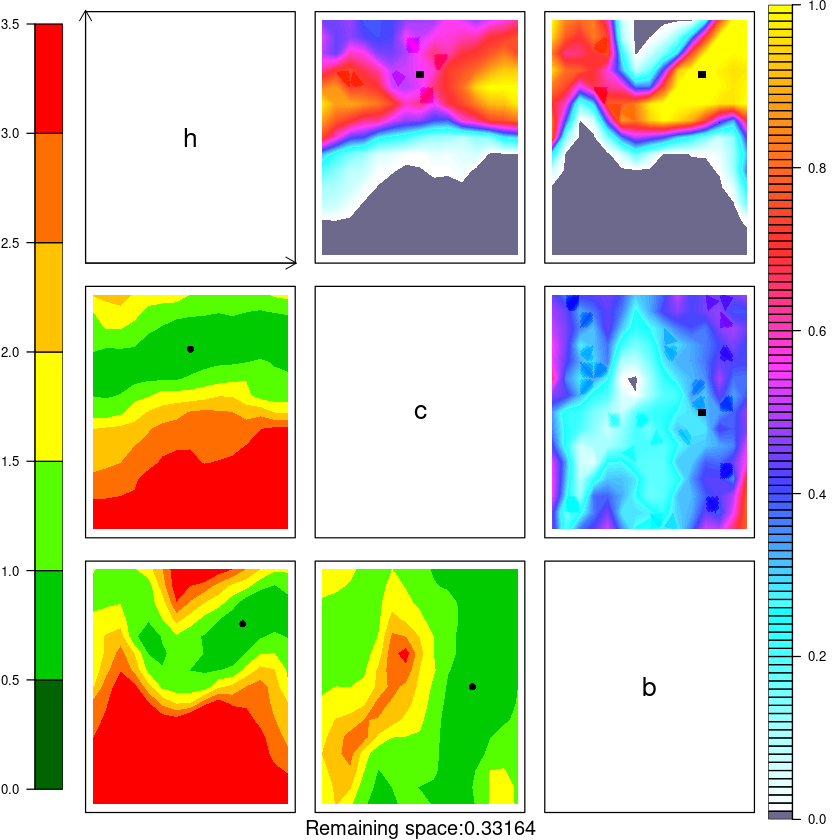

In [24]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY,sep=""), side=1)

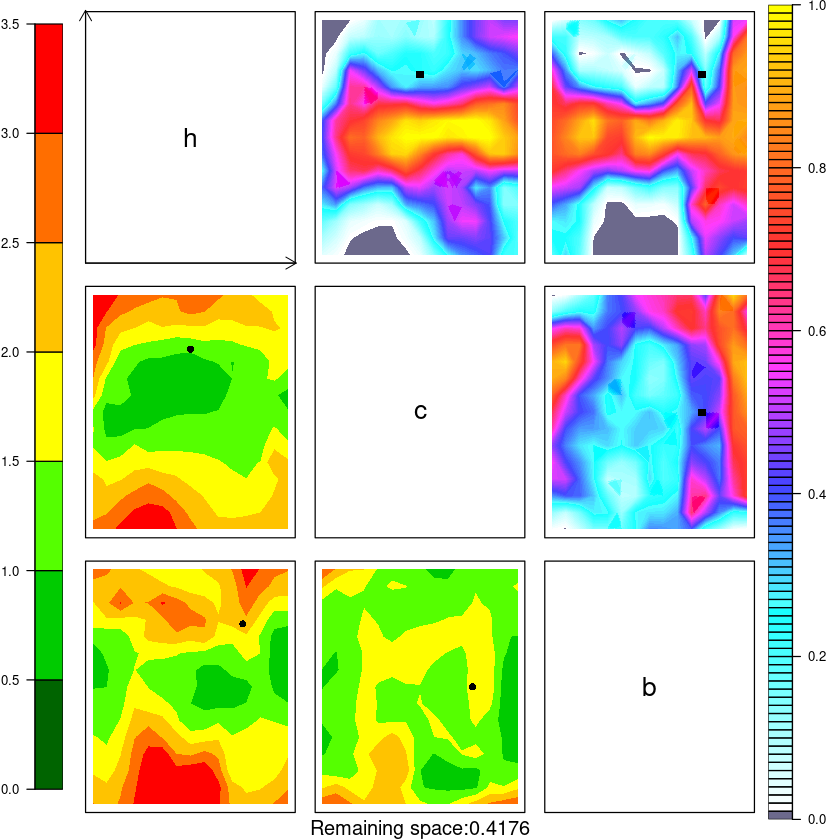

In [25]:
ImpData_wave1_pca = cbind(Xp, Timps_pca)
ImpListM1_pca = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1_pca, nEms=em_wave1_pca$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1_pca,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY_pca,sep=""), side=1)

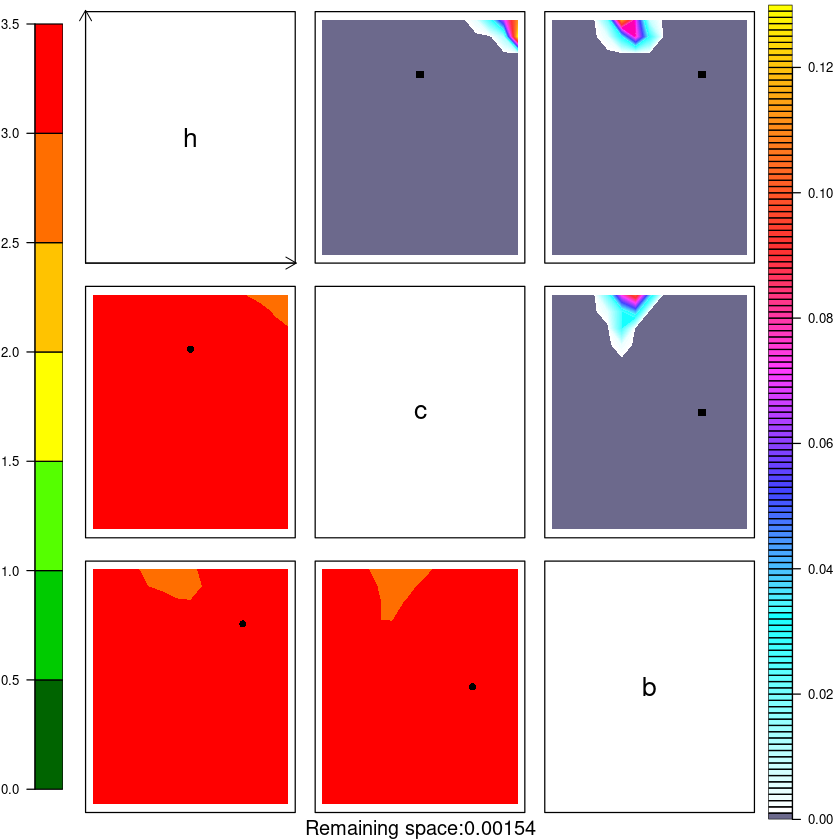

In [26]:
ImpData_wave1_ae = cbind(Xp, Timps_ae)
ImpListM1_ae = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1_ae, nEms=em_wave1_ae$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1_ae,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY_ae,sep=""), side=1)

## Second Wave

In [27]:
n <- ceiling(n_samples*1.3/scoreNROY1)

ERROR: Error in eval(expr, envir, enclos): object 'scoreNROY1' not found


In [ ]:
space <- skSpace$Space(list(c(-1, 1), c(-1, 1), c(-1, 1))) ## we use a scaled space
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
imp_em1_wave2 <- ImplausibilityMOGP(NewData=inputs_wave2_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_temp_wave2 <- which(rowSums(imp_em1_wave2 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

In [ ]:
input_wave2_scaled <- inputs_wave2_scaled_temp[sample(NROY_temp_wave2, n_samples),]
input_wave2 <- rangeUnscale(input_wave2_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,2))
plot(input_wave2[,1], input_wave2[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,1], input_wave2[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,2], input_wave2[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave2 = future_sapply(1:nrow(input_wave2), function(r) extract_metrics_AMIP(input_wave2[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave2_scaled <- data.frame(input_wave2_scaled)
names(input_wave2_scaled) <- c('h', 'c', 'b')


metrics_k_wave2 <- data.frame(t(metrics_wave2)[, metrics_index_k])
N = nrow(metrics_k_wave2) 
noise <- rnorm(N, 0, 0)
tData_wave2 <- data.frame(cbind(input_wave2_scaled, noise, metrics_k_wave2))
names(tData_wave2)[names(tData_wave2) == "noise"] <- "Noise"
         
head(tData_wave2)

### Training emulator

In [ ]:
em_wave2 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(metrics_wave2), meanFun = "fitted", additionalVariables = cands) # 

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave2, which.emulator = 4, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave2$fitting.elements$Design))
Xp_wave2 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave2) <- names(em_wave2$fitting.elements$Design)
system.time(Timps_wave2 <- ImplausibilityMOGP(NewData=Xp_wave2, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

Warning : Here we set valmax to 3 to generate a more steady NROY space

In [ ]:
valmax = 3 #Set to 3 in order to have a "more steady" NROY space
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp_wave2)[1]

### Layout of NROY space

In [ ]:
ImpData_wave2 = cbind(Xp_wave2, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [ ]:
n <- ceiling(n_samples*1.3/scoreNROY2)

In [ ]:
inputs_wave3_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
imp_em1 <- ImplausibilityMOGP(NewData=inputs_wave3_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em1 <- which(rowSums(imp_em1 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

imp_em2 <- ImplausibilityMOGP(NewData=inputs_wave3_scaled_temp, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em2 <- which(rowSums(imp_em2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)

In [ ]:
NROY_temp_wave3 <- sample(intersect(NROY_em1, NROY_em2), n_samples)

In [ ]:
input_wave3_scaled <- inputs_wave3_scaled_temp[sample(NROY_temp_wave3, n_samples),]
input_wave3 <- rangeUnscale(input_wave3_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,2))
plot(input_wave3[,1], input_wave3[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,1], input_wave3[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,2], input_wave3[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave3 = future_sapply(1:nrow(input_wave3), function(r) extract_metrics_AMIP(input_wave3[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave3_scaled <- data.frame(input_wave3_scaled)
names(input_wave3_scaled) <- c('h', 'c', 'b')


metrics_k_wave3 <- data.frame(t(metrics_wave3)[, metrics_index_k])
N = nrow(metrics_k_wave3) 
noise <- rnorm(N, 0, 0)
tData_wave3 <- data.frame(cbind(input_wave3_scaled, noise, metrics_k_wave3))
names(tData_wave3)[names(tData_wave3) == "noise"] <- "Noise"
         
head(tData_wave3)

### Training emulator

In [ ]:
em_wave3 <- BuildNewEmulators(tData_wave3, HowManyEmulators = ncol(metrics_wave3), meanFun = "fitted", additionalVariables = cands) # 

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave3, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave3$fitting.elements$Design))
Xp_wave3 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave3) <- names(em_wave3$fitting.elements$Design)
system.time(Timps_wave3 <- ImplausibilityMOGP(NewData=Xp_wave3, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 1 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp_wave3)[1]

### Layout of NROY space

In [ ]:
ImpData_wave3 = cbind(Xp_wave3, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)

## Fourth Wave

In [ ]:
n <- ceiling(n_samples*3/scoreNROY3)

In [ ]:
inputs_wave4_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [ ]:
imp_em1 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em1 <- which(rowSums(imp_em1 <= cutoff) >= em_wave1$mogp$n_emulators -valmax)

imp_em2 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em2 <- which(rowSums(imp_em2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)

imp_em3 <- ImplausibilityMOGP(NewData=inputs_wave4_scaled_temp, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
NROY_em3 <- which(rowSums(imp_em3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)

In [ ]:
inter12 <- intersect(NROY_em1, NROY_em2)
NROY_em1.2.3 <- intersect(inter12, NROY_em3)

In [ ]:
NROY_temp_wave4 <- sample(NROY_em1.2.3, n_samples)

In [ ]:
input_wave4_scaled <- inputs_wave4_scaled_temp[sample(NROY_temp_wave4, n_samples),]
input_wave4 <- rangeUnscale(input_wave4_scaled, my_bounds, range = c(-1, 1))

In [ ]:
par(mfrow=c(2,2))
plot(input_wave4[,1], input_wave4[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,1], input_wave4[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave4[,2], input_wave4[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [ ]:
metrics_wave4 = future_sapply(1:nrow(input_wave4), function(r) extract_metrics_AMIP(input_wave4[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [ ]:
input_wave4_scaled <- data.frame(input_wave4_scaled)
names(input_wave4_scaled) <- c('h', 'c', 'b')


metrics_k_wave4 <- data.frame(t(metrics_wave4)[, metrics_index_k])
N = nrow(metrics_k_wave4) 
noise <- rnorm(N, 0, 0)
tData_wave4 <- data.frame(cbind(input_wave4_scaled, noise, metrics_k_wave4))
names(tData_wave4)[names(tData_wave4) == "noise"] <- "Noise"
         
head(tData_wave4)

### Training emulator

In [ ]:
em_wave4 <- BuildNewEmulators(tData_wave4, HowManyEmulators = ncol(metrics_wave4), meanFun = "fitted", additionalVariables = cands) # 

We can use Leave One Out to verify if our GPs fit our metrics correctly.

In [ ]:
tLOOs <- LOO.plot(Emulators = em_wave4, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [ ]:
sample_size <- 100000
nparam <- length(names(em_wave4$fitting.elements$Design))
Xp_wave4 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave4) <- names(em_wave4$fitting.elements$Design)
system.time(Timps_wave4 <- ImplausibilityMOGP(NewData=Xp_wave4, Emulator=em_wave4, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY4 <- which(rowSums(Timps_wave4 <= cutoff) >= em_wave4$mogp$n_emulators -valmax)
scoreNROY4 <- length(NROY4)/dim(Xp_wave4)[1]

### Layout of NROY space

In [ ]:
ImpData_wave4 = cbind(Xp_wave4, Timps_wave4)
ImpListM4 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave4, nEms=em_wave4$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM4,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY4,sep=""), side=1)